In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os import path

In [2]:
if path.exists('./data/interaction_matrix.p'):
    interaction_matrix = pickle.load(open('./data/interaction_matrix.p', 'rb'))
else:
    from db_manager import users, repositories, close

    users_count = users.count_documents({})
    repos_count = repositories.count_documents({'$and': [{'disabled': False}, {'archived': False}]})

    # select users from the database
    all_users = list(users.find({}))
    # select repos from the database
    all_repos = list(repositories.find({'$and': [{'disabled': False}, {'archived': False}]}))

    users_id_map = {}
    repos_id_map = {}
    user_id_counter = 0
    repo_id_counter = 0

    interaction_matrix = np.zeros((users_count, repos_count), np.int8)
    for user in all_users:
        if user['_id'] not in users_id_map:
            users_id_map[user['_id']] = user_id_counter
            user_id_counter += 1

        current_user_id = users_id_map[user['_id']]

        for repo in all_repos:
            # archived or disabled repositorues should not be considered
            if repo['archived'] is True or repo['disabled'] is True:
                continue

            if repo['_id'] not in repos_id_map:
                repos_id_map[repo['_id']] = repo_id_counter
                repo_id_counter += 1
            
            current_repo_id = repos_id_map[repo['_id']]
            
            # watch interaction
            watched_repos = user['subscriptions_id']
            if repo['_id'] in watched_repos:
                interaction_matrix[current_user_id, current_repo_id] = 1
            # star interaction
            starred_repos = user['starred_repos_id']
            if repo['_id'] in starred_repos:
                interaction_matrix[current_user_id, current_repo_id] = 1
            # fork interaction
            fork_repos = user['fork_repos_id']
            if repo['_id'] in fork_repos:
                interaction_matrix[current_user_id, current_repo_id] = 1
            # own interaction
            own_repos = user['own_repos_id']
            if repo['_id'] in own_repos:
                interaction_matrix[current_user_id, current_repo_id] = 1

    close()
    pickle.dump(interaction_matrix, open('./data/interaction_matrix.p', 'wb'))

In [6]:
users_per_repo = np.sum(interaction_matrix, axis=0)

7054

{'whiskers': [<matplotlib.lines.Line2D at 0x7f95526a33d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f95526b1eb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f95526a3ee0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f95526c1760>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f95526d0970>],
 'means': []}

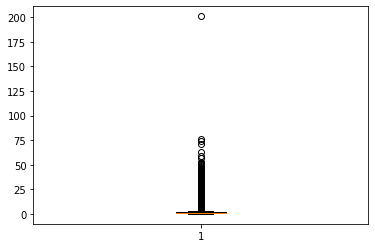

In [9]:
plt.boxplot(users_per_repo)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f95523e1220>,
 'caps': [<matplotlib.lines.Line2D at 0x7f95523f0760>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f95523e1d60>],
 'medians': [<matplotlib.lines.Line2D at 0x7f95524002e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f955240f7c0>],
 'means': []}

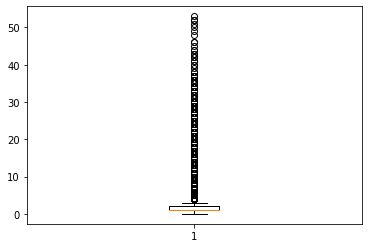

In [12]:
plt.boxplot(users_per_repo[users_per_repo<55])

In [13]:
# remove outliner
users_per_repo = users_per_repo[users_per_repo<55]

Text(0.5, 1.0, 'Distribution of users per repository')

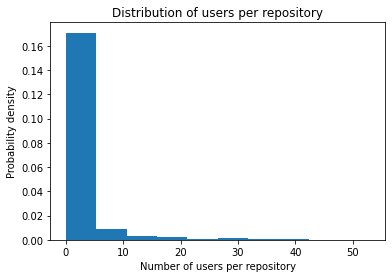

In [24]:
plt.hist(users_per_repo, density=True)
plt.xlabel('Number of users per repository')
plt.ylabel('Probability density')
plt.title('Distribution of users per repository')

In [17]:
arg_sort = np.argsort(users_per_repo)[::-1]
sorted_users_per_repo = users_per_repo[arg_sort]

Text(0.5, 1.0, 'Distribution of users per repository')

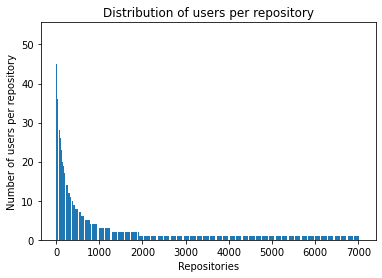

In [22]:
# plt.bar(range(len(sorted_users_per_repo)), sorted_users_per_repo, tick_label=arg_sort)
plt.bar(range(len(sorted_users_per_repo)), sorted_users_per_repo)
plt.xlabel('Repositories')
plt.ylabel('Number of users per repository')
plt.title('Distribution of users per repository')